In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install yfinance
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import re
import yfinance as yf
import holidays
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     |████████████████████████████████| 62 kB 554 kB/s eta 0:00:01
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda 4.9.2 requires ruamel_yaml>=0.11.14, which is not installed.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.


Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

/kaggle/input/us-equities-news-data/us_equities_news_dataset.csv
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/analyst_ratings_processed.csv
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_analyst_ratings.csv
/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/raw_partner_headlines.csv


In [ ]:
import torch.nn.functional as F
def SentimentAnalyzer(doc):
    pt_batch = tokenizer(doc,padding=True,truncation=True,max_length=512,return_tensors="pt")
    outputs = model(**pt_batch)
    pt_predictions = F.softmax(outputs.logits, dim=-1)
    return pt_predictions.detach().cpu().numpy()

In [4]:
data1 = pd.read_csv('/kaggle/input/massive-stock-news-analysis-db-for-nlpbacktests/analyst_ratings_processed.csv', index_col=0)
data1.dropna(inplace = True)
data1.rename(columns={'stock':'ticker'}, inplace=True)
data1['date'] = data1['date'].apply(lambda x : x.split()[0])
data2 = pd.read_csv('/kaggle/input/us-equities-news-data/us_equities_news_dataset.csv', index_col=0)
data2.dropna(inplace = True)
data2.reset_index(drop=True, inplace=True)
data2.rename(columns={'release_date':'date'}, inplace=True)
data2.drop(inplace=True, columns=['category', 'content', 'provider', 'url', 'article_id'], axis=1)

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
data = pd.concat([data1, data2])
data.drop_duplicates(subset='title', keep='first', inplace=True)

In [ ]:
data

In [45]:
data2.shape

(221505, 3)

In [10]:
tickerSymbol = "MSFT"

In [11]:
tmpData = {}
total = data['date'].nunique()
for i in tqdm(data[data['ticker']==tickerSymbol]['date'].unique()):
    tmpData[i] = data.loc[(data['ticker']==tickerSymbol) & (data['date'] == i)]['title'].tolist()

100%|██████████| 1747/1747 [03:20<00:00,  8.73it/s]


In [12]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()
def next_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    next_day = datetimeObj + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

In [13]:
def findPercentageBySentences(sentenceList):
    posAvg, negAvg, neuAvg = 0, 0, 0
    sentimentArr = SentimentAnalyzer(sentenceList)
    sentimentArr = np.mean(sentimentArr, axis=0)
    posAvg=sentimentArr[0]
    negAvg=sentimentArr[1]
    neuAvg=sentimentArr[2]
    return {'numArticles': len(sentenceList), 'pos': posAvg, 'neg': negAvg, 'neu' : neuAvg}

In [14]:
dateSentimentGroups = {}
for i in tqdm(tmpData):
    scores = findPercentageBySentences(tmpData[i])
    dateSentimentGroups[i] = scores

100%|██████████| 1747/1747 [06:27<00:00,  4.51it/s]


In [15]:
data = []
ticker = yf.Ticker(tickerSymbol)
hist = ticker.history(period="max")
for i in tqdm(dateSentimentGroups):
  start = i
  nextDay = next_business_day(start).strftime("%Y-%m-%d")
  try:
    prevDay = hist.loc[start]
    nextDay = hist.loc[nextDay]
#     data.append([i, dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg'], percentageChange])
    data.append([dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg'], prevDay['Open'], prevDay['Close']])
  except:
    pass

100%|██████████| 1747/1747 [00:01<00:00, 1139.09it/s]


In [16]:
# df = pd.DataFrame(columns =['date', 'numArticles', 'neutral', 'positive','negative','percentageChange'], data=data)
df = pd.DataFrame(columns =['numArticles', 'neutral', 'positive','negative','Open', 'Close'], data=data)

In [17]:
df

,numArticles,neutral,positive,negative,Open,Close
0,10,0.572454,0.304759,0.122787,162.022309,162.539017
1,3,0.372715,0.078984,0.548301,162.500018,162.324539
2,6,0.729227,0.219297,0.051477,163.201982,161.544617
3,5,0.558308,0.162991,0.278701,163.221483,162.909515
4,11,0.650802,0.322219,0.026979,160.228472,162.002823
...,...,...,...,...,...,...
1435,1,0.585975,0.377245,0.036780,24.858303,24.988665
1436,1,0.903279,0.081999,0.014722,21.358324,21.254564
1437,1,0.055446,0.154595,0.789959,25.141448,24.663874
1438,1,0.039728,0.843559,0.116713,26.023750,26.242298


In [18]:
X = df[['neutral', 'positive', 'negative', 'Open']]
y = df['Close']

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1)

In [20]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

In [21]:
def build_and_compile_model(norm):
    model = Sequential()
    model.add(norm)
    model.add(Dense(256, activation=lambda x : tf.nn.leaky_relu(x, alpha=0.01),  input_dim=3))
    model.add(Dense(256, activation=lambda x : tf.nn.leaky_relu(x, alpha=0.01)))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))
    return model

In [22]:
dnn_model = build_and_compile_model(normalizer)

In [23]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 256)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 67,338
Trainable params: 67,329
Non-trainable params: 9
_________________________________________________________________


In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
history = dnn_model.fit(X_train, Y_train, validation_split=0.2, epochs=1000, batch_size=100, verbose=1, callbacks=[es])

Epoch 1/1000
11/11 [==============================] - 3s 57ms/step - loss: 5932.8629 - val_loss: 6047.1230
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 5338.9387 - val_loss: 5459.7271
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 4883.0679 - val_loss: 4531.5767
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 3753.8344 - val_loss: 3275.0574
Epoch 5/1000
11/11 [==============================] - 0s 6ms/step - loss: 2615.0243 - val_loss: 1931.0177
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 1509.5256 - val_loss: 975.7249
Epoch 7/1000
11/11 [==============================] - 0s 6ms/step - loss: 771.6041 - val_loss: 561.9497
Epoch 8/1000
11/11 [==============================] - 0s 8ms/step - loss: 475.8327 - val_loss: 370.9093
Epoch 9/1000
11/11 [==============================] - 0s 7ms/step - loss: 313.0974 - val_loss: 292.1626
Epoch 10/1000
11/11 [==============================]

In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Closing Price]')
  plt.legend()
  plt.grid(True)

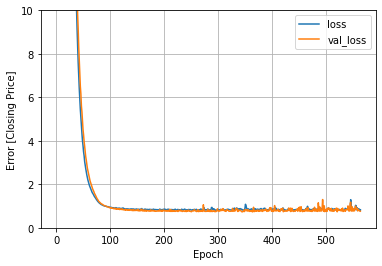

In [26]:
plot_loss(history)

In [27]:
preds = dnn_model.predict(X_test)

In [28]:
dnn_model.evaluate(X_test, Y_test, verbose=1)

5/5 [==============================] - 0s 2ms/step - loss: 0.8320


0.8319823741912842

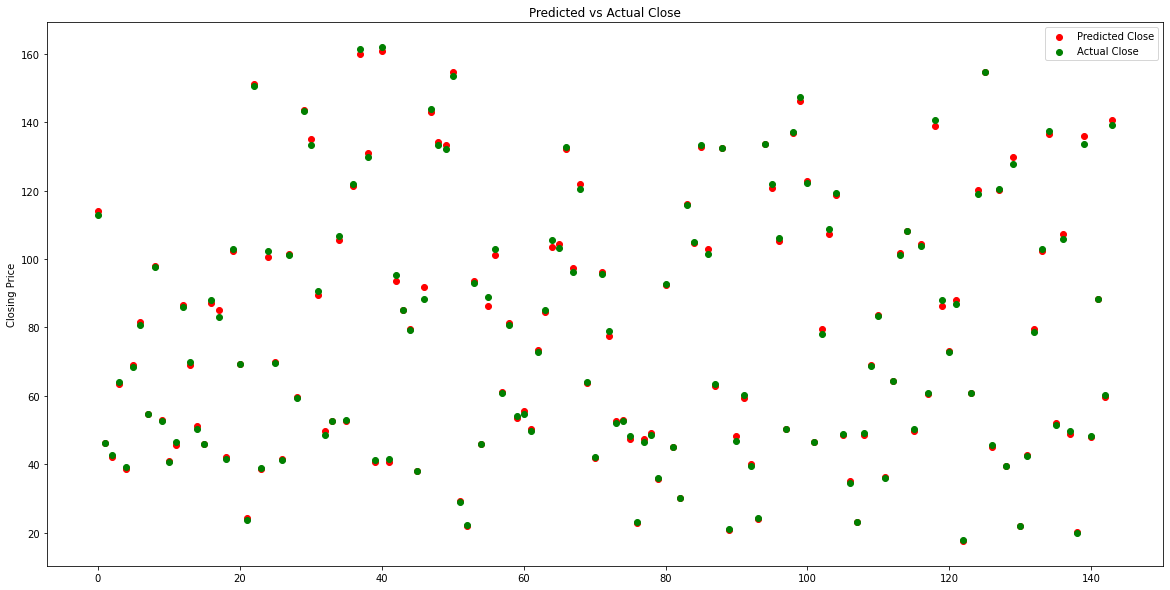

In [31]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
X = [i for i in range(len(preds))]
  
# Assign variables to the y axis part of the curve
y = preds
z = Y_test
  
# Plotting both the curves simultaneously
plt.scatter(X, y, color='r', label='Predicted Close')
plt.scatter(X, z, color='g', label='Actual Close')
  
# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Closing Price")
plt.title("Predicted vs Actual Close")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

In [30]:
dnn_model.save("finbert_msft.h5")

In [ ]:
#

# Fine-tune FinBERT 

In [63]:
data = pd.concat([data1, data2])
data.drop_duplicates(subset='title', keep='first', inplace=True)

In [52]:
data[data['ticker'] == 'A']

,title,date,ticker
0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,A
1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,A
2.0,71 Biggest Movers From Friday,2020-05-26,A
3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,A
4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22,A
...,...,...,...
106477.0,Important Step Backwards For Pension Reforms I...,2012-07-13,A
106478.0,A Look At Forecasts For Peak Oil And The End...,2012-07-15,A
106480.0,USD CHF In Final Leg Of A Wave 3 Targets At 0 ...,2012-07-20,A
106481.0,The Euro As The SDR Of Europe,2012-07-26,A


In [36]:
print(data[['date']].max(), data[['date']].min())

date    2020-06-11
dtype: object date    2008-10-02
dtype: object


In [58]:
data['ticker'].unique().tolist()[1:]

['AAMC',
 'AAME',
 'AAN',
 'AAOI',
 'AAON',
 'AAP',
 'AAPL',
 'AAU',
 'AAV',
 'AAVL',
 'AAWW',
 'AAXJ',
 'AB',
 'ABAC',
 'ABAX',
 'ABB',
 'ABBV',
 'ABC',
 'ABCB',
 'ABCD',
 'ABCO',
 'ABCW',
 'ABDC',
 'ABEV',
 'ABG',
 'ABGB',
 'ABIO',
 'ABM',
 'ABMD',
 'ABR',
 'ABTL',
 'ABX',
 'ABY',
 'ACAD',
 'ACAS',
 'ACAT',
 'ACC',
 'ACCO',
 'ACCU',
 'ACE',
 'ACET',
 'ACFC',
 'ACFN',
 'ACG',
 'ACGL',
 'ACH',
 'ACHC',
 'ACHN',
 'ACIW',
 'ACLS',
 'ACM',
 'ACMP',
 'ACN',
 'ACNB',
 'ACOR',
 'ACP',
 'ACPW',
 'ACRE',
 'ACRX',
 'ACSF',
 'ACST',
 'ACT',
 'ACTA',
 'ACTG',
 'ACTS',
 'ACU',
 'ACUR',
 'ACWI',
 'ACWV',
 'ACWX',
 'ACXM',
 'ACY',
 'ADAT',
 'ADBE',
 'ADC',
 'ADEP',
 'ADES',
 'ADGE',
 'ADHD',
 'ADI',
 'ADK',
 'ADM',
 'ADMA',
 'ADMP',
 'ADMS',
 'ADNC',
 'ADP',
 'ADPT',
 'ADRA',
 'ADRD',
 'ADRE',
 'ADRU',
 'ADS',
 'ADSK',
 'ADT',
 'ADTN',
 'ADVS',
 'ADX',
 'ADXS',
 'ADZ',
 'AE',
 'AEB',
 'AEC',
 'AEE',
 'AEG',
 'AEGN',
 'AEGR',
 'AEHR',
 'AEIS',
 'AEL',
 'AEM',
 'AEO',
 'AEPI',
 'AER',
 'AERI',
 'AES',

In [ ]:
%%time
for i, tickerSymbol in tqdm(enumerate(data['ticker'].unique().tolist())):
    yfticker = yf.Ticker(tickerSymbol)
    hist = yfticker.history(period="max").reset_index()
    if hist.size < 1:
        continue
    hist['ticker'] = tickerSymbol
    hist['Date'] = hist['Date'].dt.strftime('%Y-%m-%d')
    #print(hist.columns)
    if i == 0:
        data = data.merge(hist, left_on = ['date', 'ticker'], right_on = ['Date', 'ticker'], suffixes=(None, '_right'), how = 'left')
    else:
        data = data.merge(hist, suffixes=(None, '_right'), how = 'left')
    #print(data[data['ticker'] == tickerSymbol])


    

1it [00:02,  2.09s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
3it [00:09,  3.19s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
4it [00:12,  3.20s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
8it [00:26,  3.67s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
10it [00:30,  2.58s/it]

- AAV: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
11it [00:34,  2.85s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
12it [00:37,  3.12s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
15it [00:46,  2.71s/it]

- ABAC: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
16it [00:50,  3.06s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
17it [00:54,  3.27s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
20it [01:05,  3.66s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
21it [01:09,  3.62s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: Us

- ABCW: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker ABDC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


24it [01:13,  2.08s/it]

- ABDC: No data found, symbol may be delisted


25it [01:17,  2.60s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
27it [01:22,  2.24s/it]

- ABGB: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
29it [01:29,  3.13s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
30it [01:33,  3.33s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
32it [01:38,  2.64s/it]

- ABTL: No data found for this date range, symbol may be delisted


33it [01:38,  2.04s/it]

- ABX: No data found for this date range, symbol may be delisted


34it [01:39,  1.61s/it]

- ABY: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
36it [01:43,  1.75s/it]

- ACAS: No data found for this date range, symbol may be delisted


37it [01:44,  1.41s/it]

- ACAT: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker ACC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


38it [01:45,  1.18s/it]

- ACC: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
39it [01:48,  1.94s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
40it [01:52,  2.34s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
41it [01:55,  2.62s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
44it [02:06,  3.33s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: Us

- ACMP: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
55it [02:43,  3.30s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
58it [02:51,  2.62s/it]

- ACPW: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
59it [02:55,  2.89s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
60it [02:58,  3.07s/it]

Got error from yahoo api for ticker ACSF, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


61it [02:59,  2.34s/it]

- ACSF: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
62it [03:02,  2.67s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
63it [03:06,  2.90s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
64it [03:09,  3.11s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
66it [03:14,  2.50s/it]

- ACTS: No data found for this date range, symbol may be delisted


67it [03:18,  2.93s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
68it [03:21,  3.16s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
69it [03:25,  3.29s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
70it [03:29,  3.37s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
72it [03:33,  2.62s/it]

- ACXM: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker ACY, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


73it [03:33,  2.02s/it]

- ACY: No data found, symbol may be delisted


74it [03:34,  1.61s/it]

- ADAT: No data found for this date range, symbol may be delisted


75it [03:38,  2.32s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
77it [03:43,  2.14s/it]

- ADEP: No data found for this date range, symbol may be delisted


79it [03:47,  2.00s/it]

- ADGE: No data found for this date range, symbol may be delisted


80it [03:48,  1.58s/it]

- ADHD: No data found for this date range, symbol may be delisted


81it [03:52,  2.34s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
83it [03:59,  3.06s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
84it [04:02,  3.16s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
85it [04:06,  3.36s/it]

Got error from yahoo api for ticker ADMS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


86it [04:07,  2.55s/it]

- ADMS: No data found, symbol may be delisted


87it [04:08,  1.98s/it]

- ADNC: No data found for this date range, symbol may be delisted


88it [04:12,  2.65s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
89it [04:15,  2.89s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
90it [04:18,  3.01s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
92it [04:58, 12.94s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
93it [05:01, 10.15s/it]

Got error from yahoo api for ticker ADS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


94it [05:02,  7.30s/it]

- ADS: No data found, symbol may be delisted


95it [05:06,  6.29s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
98it [05:14,  3.68s/it]

- ADVS: No data found for this date range, symbol may be delisted


99it [05:18,  3.83s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
100it [05:22,  3.73s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
102it [05:29,  3.76s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
104it [05:33,  2.79s/it]

- AEC: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
106it [05:41,  3.41s/it]

Got error from yahoo api for ticker AEGN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


107it [05:42,  2.57s/it]

- AEGN: No data found, symbol may be delisted


108it [05:43,  1.98s/it]

- AEGR: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
109it [05:46,  2.50s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
110it [05:50,  2.88s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
111it [05:54,  3.11s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
114it [06:02,  2.67s/it]

- AEPI: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
115it [06:06,  2.94s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
118it [06:17,  3.50s/it]

Got error from yahoo api for ticker AETI, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


119it [06:18,  2.64s/it]

- AETI: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
120it [06:22,  2.97s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
122it [06:26,  2.42s/it]

- AF: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker AFA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


123it [06:27,  1.88s/it]

- AFA: No data found, symbol may be delisted


124it [06:30,  2.45s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
125it [06:34,  2.85s/it]

Got error from yahoo api for ticker AFC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


126it [06:35,  2.19s/it]

- AFC: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
128it [06:39,  1.99s/it]

- AFFX: No data found for this date range, symbol may be delisted


129it [06:43,  2.68s/it]

Got error from yahoo api for ticker AFH, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


130it [06:44,  2.06s/it]

- AFH: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
132it [06:52,  3.01s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
134it [06:55,  2.36s/it]

- AFOP: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
135it [06:59,  2.76s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
136it [07:03,  3.01s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
137it [07:06,  3.23s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
138it [07:10,  3.32s/it]

Got error from yahoo api for ticker AGC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


139it [07:11,  2.50s/it]

- AGC: No data found, symbol may be delisted


140it [07:15,  2.96s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
141it [07:18,  3.18s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
142it [07:22,  3.30s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
144it [07:26,  2.57s/it]

- AGII: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
146it [07:34,  3.16s/it]

Got error from yahoo api for ticker AGN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


147it [07:34,  2.39s/it]

- AGN: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
148it [07:38,  2.78s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
149it [07:41,  3.00s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
150it [07:45,  3.28s/it]

Got error from yahoo api for ticker AGOL, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


151it [07:46,  2.48s/it]

- AGOL: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
152it [07:49,  2.80s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
153it [07:53,  3.02s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
154it [07:56,  3.13s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
156it [08:01,  2.46s/it]

- AGU: No data found for this date range, symbol may be delisted


158it [08:08,  3.23s/it]

Got error from yahoo api for ticker AHC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


159it [08:09,  2.45s/it]

- AHC: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
160it [08:13,  2.77s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
161it [08:16,  3.04s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
163it [08:20,  2.43s/it]

- AHP: No data found for this date range, symbol may be delisted


165it [08:28,  3.09s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
166it [08:31,  3.19s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
167it [08:35,  3.35s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
168it [08:38,  3.35s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
170it [08:46,  3.64s/it]/opt/conda/lib/python3.7/site-packages/pandas/co

Got error from yahoo api for ticker AINV, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


174it [08:58,  2.73s/it]

- AINV: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
177it [09:06,  2.57s/it]

- AIRM: No data found for this date range, symbol may be delisted


181it [09:19,  2.69s/it]

- AIXG: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
183it [09:27,  3.30s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
184it [09:30,  3.40s/it]

Got error from yahoo api for ticker AKAO, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


185it [09:31,  2.57s/it]

- AKAO: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
186it [09:35,  2.87s/it]

Got error from yahoo api for ticker AKER, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


187it [09:35,  2.20s/it]

- AKER: No data found, symbol may be delisted
Got error from yahoo api for ticker AKG, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


188it [09:36,  1.74s/it]

- AKG: No data found, symbol may be delisted
Got error from yahoo api for ticker AKP, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


189it [09:37,  1.40s/it]

- AKP: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
190it [09:40,  2.13s/it]

Got error from yahoo api for ticker AKRX, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


191it [09:41,  1.68s/it]

- AKRX: No data found, symbol may be delisted
Got error from yahoo api for ticker AKS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


192it [09:42,  1.37s/it]

- AKS: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
195it [09:53,  2.99s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
196it [09:56,  3.10s/it]

Got error from yahoo api for ticker ALDR, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


197it [09:57,  2.35s/it]

- ALDR: No data found, symbol may be delisted


198it [09:58,  1.85s/it]

- ALDW: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
200it [10:05,  2.88s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
201it [10:09,  3.07s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
202it [10:12,  3.19s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
203it [10:16,  3.41s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145

- ALJ: No data found for this date range, symbol may be delisted


208it [10:32,  3.09s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
211it [10:40,  2.61s/it]

- ALLB: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
212it [10:43,  2.87s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
214it [10:50,  3.20s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
217it [11:02,  3.61s/it]

Got error from yahoo api for ticker ALQA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


218it [11:02,  2.71s/it]

- ALQA: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
219it [11:06,  2.96s/it]

Got error from yahoo api for ticker ALSK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


220it [11:07,  2.25s/it]

- ALSK: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
221it [11:10,  2.63s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
223it [11:14,  2.17s/it]

- ALTV: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
225it [11:21,  2.85s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
227it [11:26,  2.43s/it]

- ALXA: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker ALXN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


228it [11:26,  1.90s/it]

- ALXN: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
229it [11:30,  2.35s/it]

Got error from yahoo api for ticker AMAG, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


230it [11:30,  1.83s/it]

- AMAG: No data found, symbol may be delisted


231it [11:34,  2.50s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
232it [11:38,  2.80s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
233it [11:41,  3.01s/it]

Got error from yahoo api for ticker AMBR, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


234it [11:42,  2.31s/it]

- AMBR: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
236it [11:46,  2.06s/it]

- AMCC: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
237it [11:50,  2.52s/it]

Got error from yahoo api for ticker AMCO, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


238it [11:50,  1.97s/it]

- AMCO: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
239it [11:54,  2.44s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
241it [11:59,  2.24s/it]

- AMDA: No data found for this date range, symbol may be delisted


242it [12:03,  2.78s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
243it [12:07,  3.09s/it]

Got error from yahoo api for ticker AMFW, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


244it [12:07,  2.36s/it]

- AMFW: No data found, symbol may be delisted


245it [12:11,  2.84s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
247it [12:15,  2.30s/it]

- AMIC: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
248it [12:19,  2.60s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
249it [12:22,  2.87s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
253it [12:37,  3.56s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
254it [12:41,  3.61s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145

Got error from yahoo api for ticker AMRB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


258it [12:52,  2.61s/it]

- AMRB: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
260it [12:56,  2.19s/it]

- AMRE: No data found for this date range, symbol may be delisted


261it [12:56,  1.72s/it]

- AMRI: No data found for this date range, symbol may be delisted


262it [13:00,  2.27s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
263it [13:04,  2.71s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
264it [13:07,  2.98s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
266it [13:12,  2.42s/it]

- AMSG: No data found for this date range, symbol may be delisted


267it [13:16,  2.90s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
268it [13:19,  3.12s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
270it [13:23,  2.43s/it]

- AMTG: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
275it [13:39,  2.54s/it]

- AMZG: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
277it [13:46,  3.20s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
279it [13:50,  2.46s/it]

- ANAD: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker ANAT, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


280it [13:51,  1.91s/it]

- ANAT: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
281it [13:54,  2.38s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
283it [14:01,  2.96s/it]

Got error from yahoo api for ticker AND, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


284it [14:02,  2.26s/it]

- AND: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
286it [14:09,  2.99s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
287it [14:13,  3.15s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
288it [14:16,  3.25s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
289it [14:20,  3.36s/it]

Got error from yahoo api for ticker ANH, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


290it [14:21,  2.54s/it]

- ANH: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
291it [14:24,  2.88s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
292it [14:28,  3.17s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
293it [14:32,  3.29s/it]

Got error from yahoo api for ticker ANTM, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


294it [14:32,  2.50s/it]

- ANTM: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
296it [14:37,  2.17s/it]

- ANW: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
299it [14:44,  2.22s/it]

- AOI: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
301it [14:49,  2.03s/it]

- AOL: No data found for this date range, symbol may be delisted


303it [14:57,  3.04s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
306it [15:05,  2.65s/it]

- APAGF: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
307it [15:08,  2.90s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
308it [15:12,  3.07s/it]

Got error from yahoo api for ticker APC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


309it [15:13,  2.35s/it]

- APC: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
310it [15:16,  2.70s/it]

Got error from yahoo api for ticker APF, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


311it [15:17,  2.07s/it]

- APF: No data found, symbol may be delisted


312it [15:21,  2.61s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
313it [15:24,  2.80s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
314it [15:27,  2.95s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
317it [15:35,  2.60s/it]

- APOL: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
319it [15:39,  2.14s/it]

- APPY: No data found for this date range, symbol may be delisted


320it [15:40,  1.68s/it]

- APRI: No data found for this date range, symbol may be delisted


321it [15:41,  1.36s/it]

- APSA: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
322it [15:44,  2.08s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
323it [15:48,  2.52s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
324it [15:51,  2.75s/it]

Got error from yahoo api for ticker AQXP, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


325it [15:52,  2.11s/it]

- AQXP: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
326it [15:55,  2.51s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
327it [15:59,  2.82s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
328it [16:03,  3.11s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
329it [16:07,  3.38s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145

Got error from yahoo api for ticker ARCI, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


331it [16:11,  2.60s/it]

- ARCI: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
332it [16:14,  2.91s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
334it [16:19,  2.36s/it]

- ARCX: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
335it [16:22,  2.71s/it]

Got error from yahoo api for ticker ARDM, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


336it [16:23,  2.09s/it]

- ARDM: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
337it [16:26,  2.47s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
338it [16:30,  2.85s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
339it [16:33,  3.02s/it]

Got error from yahoo api for ticker AREX, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


340it [16:34,  2.30s/it]

- AREX: No data found, symbol may be delisted


341it [16:35,  1.81s/it]

- ARGS: No data found for this date range, symbol may be delisted


342it [16:38,  2.36s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
344it [16:42,  2.08s/it]

- ARIA: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
345it [16:46,  2.55s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
346it [16:49,  2.74s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
347it [16:53,  2.96s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
348it [16:56,  3.09s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145

- ARMH: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
355it [17:18,  2.92s/it]

Got error from yahoo api for ticker ARNA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


356it [17:19,  2.23s/it]

- ARNA: No data found, symbol may be delisted


357it [17:20,  1.75s/it]

- ARO: No data found for this date range, symbol may be delisted


359it [17:24,  1.89s/it]

- ARPI: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker ARQL, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


360it [17:25,  1.51s/it]

- ARQL: No data found, symbol may be delisted


361it [17:28,  2.08s/it]

Got error from yahoo api for ticker ARRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


362it [17:29,  1.64s/it]

- ARRS: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
365it [17:40,  3.04s/it]

Got error from yahoo api for ticker ARTX, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


366it [17:41,  2.31s/it]

- ARTX: No data found, symbol may be delisted


367it [17:45,  2.77s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
371it [17:57,  2.67s/it]

- ASBI: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
372it [18:01,  2.92s/it]

Got error from yahoo api for ticker ASCMA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


373it [18:01,  2.23s/it]

- ASCMA: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
374it [18:05,  2.64s/it]

Got error from yahoo api for ticker ASFI, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


375it [18:05,  2.04s/it]

- ASFI: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
377it [18:13,  3.06s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
378it [18:17,  3.15s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
379it [18:20,  3.27s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
381it [18:24,  2.53s/it]

- ASMI: No data found for this date range, symbol may be delisted


382it [18:28,  2.87s/it]

Got error from yahoo api for ticker ASNA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


383it [18:29,  2.21s/it]

- ASNA: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
385it [18:33,  2.01s/it]

- ASPX: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
387it [18:41,  3.02s/it]

Got error from yahoo api for ticker AST, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


388it [18:41,  2.31s/it]

- AST: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
390it [18:49,  3.00s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
392it [18:56,  3.32s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
393it [19:00,  3.49s/it]

Got error from yahoo api for ticker AT, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


394it [19:01,  2.64s/it]

- AT: No data found, symbol may be delisted


396it [19:05,  2.29s/it]

- ATE: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
397it [19:09,  2.65s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
398it [19:12,  2.88s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
399it [19:15,  3.07s/it]

Got error from yahoo api for ticker ATHN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


400it [19:16,  2.34s/it]

- ATHN: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
401it [19:20,  2.65s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
403it [19:24,  2.27s/it]

- ATK: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
404it [19:27,  2.57s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
406it [19:35,  3.15s/it]

Got error from yahoo api for ticker ATLS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


407it [19:35,  2.40s/it]

- ATLS: No data found, symbol may be delisted


408it [19:36,  1.87s/it]

- ATML: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
410it [19:43,  2.83s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
412it [19:47,  2.29s/it]

- ATNY: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
413it [19:51,  2.60s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
415it [19:58,  3.16s/it]

Got error from yahoo api for ticker ATRM, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


416it [19:59,  2.40s/it]

- ATRM: No data found, symbol may be delisted


417it [20:03,  2.87s/it]

Got error from yahoo api for ticker ATRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


418it [20:03,  2.20s/it]

- ATRS: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
420it [20:10,  2.84s/it]

Got error from yahoo api for ticker ATTU, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


421it [20:11,  2.18s/it]

- ATTU: No data found, symbol may be delisted
Got error from yahoo api for ticker ATU, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


422it [20:11,  1.72s/it]

- ATU: No data found, symbol may be delisted
Got error from yahoo api for ticker ATV, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


423it [20:12,  1.40s/it]

- ATV: No data found, symbol may be delisted


424it [20:16,  2.08s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
425it [20:19,  2.45s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
429it [20:31,  2.52s/it]

- AUMA: No data found for this date range, symbol may be delisted


430it [20:32,  1.95s/it]

- AUMAU: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
431it [20:35,  2.40s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
433it [20:39,  2.09s/it]

- AUQ: No data found for this date range, symbol may be delisted


434it [20:40,  1.66s/it]

- AUXL: No data found for this date range, symbol may be delisted


436it [20:44,  1.77s/it]

- AV: No data found for this date range, symbol may be delisted


437it [20:48,  2.46s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
438it [20:52,  2.75s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
439it [20:55,  2.99s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
441it [21:03,  3.37s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
442it [21:06,  3.42s/it]/opt/conda/lib/python3.7/site-packages/pandas/co

Got error from yahoo api for ticker AVH, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


445it [21:14,  2.60s/it]

- AVH: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
446it [21:17,  2.80s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
447it [21:21,  3.07s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
448it [21:24,  3.12s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
450it [21:28,  2.49s/it]

- AVL: No data found for this date range, symbol may be delisted


451it [21:29,  1.92s/it]

- AVNR: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
452it [21:33,  2.49s/it]

Got error from yahoo api for ticker AVOL, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


453it [21:33,  1.93s/it]

- AVOL: No data found, symbol may be delisted
Got error from yahoo api for ticker AVP, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


454it [21:34,  1.54s/it]

- AVP: No data found, symbol may be delisted


455it [21:38,  2.37s/it]

Got error from yahoo api for ticker AVX, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


456it [21:39,  1.87s/it]

- AVX: No data found, symbol may be delisted


457it [21:43,  2.51s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
458it [21:46,  2.74s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
459it [21:50,  3.08s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
460it [21:53,  3.20s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
461it [21:57,  3.33s/it]/opt/conda/lib/python3.7/site-packages/pandas/co

Got error from yahoo api for ticker AXE, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


469it [22:24,  2.75s/it]

- AXE: No data found, symbol may be delisted


470it [22:28,  3.06s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
471it [22:31,  3.19s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
472it [22:34,  3.25s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
474it [22:39,  2.58s/it]

- AXLL: No data found for this date range, symbol may be delisted


475it [22:40,  2.00s/it]

- AXN: No data found for this date range, symbol may be delisted


477it [22:44,  2.03s/it]

- AXPW: No data found for this date range, symbol may be delisted


478it [22:48,  2.57s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
479it [22:52,  2.89s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
480it [22:55,  3.04s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
481it [22:59,  3.21s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
482it [23:02,  3.29s/it]

Got error from yahoo api for ticker AXX, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


483it [23:03,  2.49s/it]

- AXX: No data found, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
484it [23:07,  2.87s/it]

Got error from yahoo api for ticker AYR, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


485it [23:07,  2.21s/it]

- AYR: No data found, symbol may be delisted


487it [23:12,  2.37s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
488it [23:15,  2.76s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
493it [23:32,  2.88s/it]

- BAA: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
494it [23:36,  3.10s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
495it [23:39,  3.23s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
496it [23:43,  3.26s/it]

Got error from yahoo api for ticker BABY, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


497it [23:43,  2.47s/it]

- BABY: No data found, symbol may be delisted


499it [23:48,  2.26s/it]

- BAGR: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
500it [23:51,  2.61s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
501it [23:55,  2.95s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
502it [23:58,  3.05s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
505it [24:06,  2.58s/it]

- BAMM: No data found for this date range, symbol may be delisted


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
508it [24:18,  3.34s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
510it [24:25,  3.47s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
511it [24:28,  3.39s/it]

Got error from yahoo api for ticker BAS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


512it [24:29,  2.56s/it]

- BAS: No data found, symbol may be delisted
Got error from yahoo api for ticker BASI, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}


513it [24:29,  2.00s/it]

- BASI: No data found, symbol may be delisted


515it [24:37,  2.92s/it]/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
517it [24:41,  2.37s/it]

- BBCN: No data found for this date range, symbol may be delisted


In [67]:
yfticker = yf.Ticker('AAV')
hist = yfticker.history(period="max").reset_index()

- AAV: No data found for this date range, symbol may be delisted


In [69]:
data1[data1['ticker'] == 'AAV']
yf.history.help()

AttributeError: module 'yfinance' has no attribute 'history'

## Label data

In [ ]:
def fixed_time_horizon(data, threshold, name='Close'):
    """Fixed-time horizon labelling.
 
    Compute the financial labels using the fixed-time horizon procedure. See
    references to understand how this method works.
 
    Parameters
    ----------
    data : pandas.DataFrame or pandas.Series
        The data from which the labels are to be calculated. The data should be
        returns and not prices.
    name : str, optional, default: 'Close'
        Column to extract the labels from.        
    threshold : int
        The predefined constant threshold to compute the labels.
 
    Returns
    -------
    labs : pandas.DataFrame
        A pandas dataframe containing the returns and the labels for each 
        return.
 
    References
    ----------
    .. [1] Marcos López de Prado (2018). Advances in Financial Machine Learning 
       Wiley & Sons, Inc.
 
    .. [2] Marcos López de Prado - Machine Learning for Asset Managers.
 
    """
    # to store labels
    labs = pd.DataFrame(index=data.index, columns=[name, 'Label'])
 
    # get indices for each label
    idx_lower = data[data[name] < -threshold].index
    idx_middle = data[abs(data[name]) <= threshold].index
    idx_upper = data[data[name] > threshold].index
 
    # assign labels depending on indices
    labs[name] = data
    labs.loc[idx_lower, 'Label'] = -1
    labs.loc[idx_middle, 'Label'] = 0
    labs.loc[idx_upper, 'Label'] = 1
 
    return labs

In [ ]:
ticker = yf.Ticker(tickerSymbol)
hist = ticker.history(period="max")
for i in tqdm(dateSentimentGroups):
  start = i
  nextDay = next_business_day(start).strftime("%Y-%m-%d")
  try:
    prevDay = hist.loc[start]
    nextDay = hist.loc[nextDay]
#     data.append([i, dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg'], percentageChange])
    data.append([dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg'], prevDay['Open'], prevDay['Close']])
  except:
    pass

In [42]:
#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)

AttributeError: 'DataFrame' object has no attribute 'map'